In [1]:
import pandas as pd
import numpy as np

In [2]:
from scipy.sparse import coo_matrix

In [3]:
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k
from lightfm import LightFM

/Users/dea/venvs/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [4]:
interactions = pd.read_csv("../data/raw/interactions.csv", parse_dates=['last_watch_dt'])

In [5]:
items = pd.read_csv("../data/raw/items.csv")

In [6]:
users = pd.read_csv("../data/raw/users.csv")

In [51]:
print("Unique users: ", interactions["user_id"].nunique())
print("Unique items: ", interactions["item_id"].nunique())

Unique users:  962179
Unique items:  15706


In [52]:
print(f'Data date range: {interactions.last_watch_dt.min().date()} - {interactions.last_watch_dt.max().date()}')

Data date range: 2021-03-13 - 2021-08-22


In [53]:
print(f'Data watched_pct range: {interactions.watched_pct.min()} - {interactions.watched_pct.max()}')

Data watched_pct range: 0.0 - 100.0


In [54]:
interactions['watched_pct'] = interactions['watched_pct'].astype(pd.Int8Dtype())

In [55]:
train = interactions[interactions["last_watch_dt"] <= interactions["last_watch_dt"].max() - pd.Timedelta(10, "d")]
test = interactions[interactions["last_watch_dt"] > interactions["last_watch_dt"].max() - pd.Timedelta(10, "d")]
print("Train dataset size:", train.shape[0])
print("Test dataset size:", test.shape[0])
print(f"Test size: {test.shape[0] / interactions.shape[0] * 100} persent")

Train dataset size: 4867782
Test dataset size: 608469
Test size: 11.111050242218628 persent


In [56]:
test_warm = test.loc[test['user_id'].isin(train['user_id'].unique())]
test_cold = test.loc[~test['user_id'].isin(train['user_id'].unique())]
print("Warm users in test:", test_warm.shape[0])
print("Cold users in test:", test_cold.shape[0])

Warm users in test: 419583
Cold users in test: 188886


In [57]:
dataset = Dataset()

In [58]:
dataset.fit(interactions['user_id'].unique(), interactions['item_id'].unique())

In [59]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('User mapper length - ', len(lightfm_mapping['users_mapping']))
print('User features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('Movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

User mapper length -  962179
User features mapper length -  962179
Movies mapper length -  15706
Movie features mapper length -  15706


In [60]:
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [61]:
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 32
EPOCHS = 20

In [62]:
shape = (len(lightfm_mapping["users_mapping"]), len(lightfm_mapping["items_mapping"]))

train_matrix = coo_matrix(
    (
        np.ones((train['user_id'].shape[0])),
        (
            train['user_id'].map(lightfm_mapping["users_mapping"]).astype(int),
            train['item_id'].map(lightfm_mapping["items_mapping"]).astype(int)
        )
    ),
    shape=shape
)
test_warm_matrix = coo_matrix(
    (
        np.ones((test_warm['user_id'].shape[0])),
        (
            test_warm['user_id'].map(lightfm_mapping["users_mapping"]).astype(int),
            test_warm['item_id'].map(lightfm_mapping["items_mapping"]).astype(int)
        )
    ), 
    shape=shape
)
test_cold_matrix = coo_matrix(
    (
        np.ones((test_cold['user_id'].shape[0])),
        (
            test_cold['user_id'].map(lightfm_mapping["users_mapping"]).astype(int),
            test_cold['item_id'].map(lightfm_mapping["items_mapping"]).astype(int)
        )
    ), 
    shape=shape
)

In [64]:
model = LightFM(loss=LOSS, no_components=NO_COMPONENTS, learning_rate=LEARNING_RATE, max_sampled=MAX_SAMPLED, random_state = RANDOM_STATE)
model.fit(train_matrix, epochs=EPOCHS, num_threads=4)

In [ ]:
# Очень длительная обработка. Время выполнения ~ 10-15 минут
k = 10
print(f"Train precision at k={k}:\t{precision_at_k(model, train_matrix, k=k).mean()}")
print(f"Test warm precision at k={k}:\t\t{precision_at_k(model, test_warm_matrix, k=k).mean()}")
print(f"Test cold precision at k={k}:\t\t{precision_at_k(model, test_cold_matrix, k=k).mean()}")

In [ ]:
# Очень длительная обработка. Время выполнения ~ 10-15 минут
k = 20
print(f"Train precision at k={k}:\t{precision_at_k(model, train_matrix, k=k).mean()}")
print(f"Test warm precision at k={k}:\t\t{precision_at_k(model, test_warm_matrix, k=k).mean()}")
print(f"Test cold precision at k={k}:\t\t{precision_at_k(model, test_cold_matrix, k=k).mean()}")

In [65]:
item_ids = list(lightfm_mapping['items_mapping'].values())
predicted = pd.DataFrame({"user_id": test['user_id'].unique()})
predicted.shape

(216400, 1)

In [66]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [67]:
watched_movies = train.groupby('user_id')['item_id'].apply(list).to_dict()

In [69]:
mapper = generate_lightfm_recs_mapper(
    model,
    item_ids = item_ids, 
    known_items = watched_movies,
    N = 20,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 20
)

In [70]:
predicted['item_id'] = predicted['user_id'].map(mapper)

In [71]:
predicted.head()

user_id                                            item_id
0  1016458  [10440, 13865, 9728, 7102, 4457, 3734, 7829, 1...
1   203219  [7107, 4880, 11237, 849, 6809, 14741, 24, 1844...
2   505244  [10440, 15297, 9728, 13865, 4151, 3734, 2657, ...
3   200197  [10440, 15297, 9728, 13865, 4151, 3734, 2657, ...
4    73446  [3734, 10440, 15297, 13865, 16166, 7829, 2657,...

In [72]:
predicted = predicted.explode('item_id')

In [73]:
predicted.head()

user_id item_id
0  1016458   10440
0  1016458   13865
0  1016458    9728
0  1016458    7102
0  1016458    4457

In [74]:
predicted['rank'] = predicted.groupby('user_id').cumcount() + 1

In [75]:
predicted.item_id.nunique()

2581

In [76]:
positive_preds = pd.merge(predicted, test, how = 'inner', on = ['user_id', 'item_id'])
positive_preds['target'] = 1
positive_preds.shape

(115828, 7)

In [77]:
negative_preds = pd.merge(predicted, test, how = 'left', on = ['user_id', 'item_id'])
negative_preds = negative_preds.loc[negative_preds['watched_pct'].isnull()].sample(frac = .2)
negative_preds['target'] = 0
negative_preds.shape

(842434, 7)

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import xgboost as xgb


In [103]:
train_users, test_users = train_test_split(
    test['user_id'].unique(),
    test_size = .2,
    random_state = 13
    )

In [104]:
train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)


In [105]:
test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [106]:
print(f'TRAIN: {train_set.describe()} \n, TEST: {test_set.describe()}')

TRAIN:             user_id           rank                  last_watch_dt  \
count  7.660180e+05  766018.000000                          92666   
mean   5.501150e+05      10.130513  2021-08-17 12:53:02.215699456   
min    1.000000e+00       1.000000            2021-08-13 00:00:00   
25%    2.763220e+05       5.000000            2021-08-15 00:00:00   
50%    5.507420e+05      10.000000            2021-08-18 00:00:00   
75%    8.249420e+05      15.000000            2021-08-20 00:00:00   
max    1.097549e+06      20.000000            2021-08-22 00:00:00   
std    3.166089e+05       5.861238                            NaN   

          total_dur  watched_pct         target  
count  9.266600e+04      92666.0  766018.000000  
mean   9.782713e+03    41.997594       0.120971  
min    1.000000e+00          0.0       0.000000  
25%    6.190000e+02          5.0       0.000000  
50%    3.755000e+03         29.5       0.000000  
75%    9.023750e+03         86.0       0.000000  
max    1.852385e+06  

In [107]:
train_set.to_pickle('../data/processed/train_set.pkl')
test_set.to_pickle('../data/processed/test_set.pkl')
predicted.to_pickle('../data/processed/local_test_preds.pkl')

## XGBoost. Загрузка подготовленных данных

In [8]:
train_set = pd.read_pickle('../data/processed/train_set.pkl')
test_set = pd.read_pickle('../data/processed/test_set.pkl')
predicted = pd.read_pickle('../data/processed/local_test_preds.pkl')

In [9]:
USER_FEATURES = ["age", "income", "sex", "kids_flg"]
ITEM_FEATURES = [
    "content_type",
    "release_year",
    "for_kids",
    "age_rating",
]

In [10]:
train_set = pd.merge(train_set, users[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])
test_set = pd.merge(test_set, users[['user_id'] + USER_FEATURES],
                        how = 'left', on = ['user_id'])

In [11]:
ID_COLS = ['user_id', 'item_id']
TARGET = 'target'
CATEGORICAL_COLS = [
    'age', 'income', 'sex', 'content_type'
]
MULTIWORDS_COLS = {

}
DROP_COLS = ['last_watch_dt', 'watched_pct', 'total_dur']

In [12]:
train_set[ID_COLS] = train_set[ID_COLS].astype(int)
test_set[ID_COLS] = test_set[ID_COLS].astype(int)

In [13]:
train_set = pd.merge(train_set, items[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
test_set = pd.merge(test_set, items[['item_id'] + ITEM_FEATURES],
                        how = 'left', on = ['item_id'])

print(train_set.shape, test_set.shape)


(766018, 15) (192244, 15)


In [14]:
train_set.head()

user_id  item_id  rank last_watch_dt  total_dur  watched_pct  target  \
0   742303     9728     2           NaT        NaN         <NA>       0   
1   839223     4457    12           NaT        NaN         <NA>       0   
2  1028485     7571    14    2021-08-20    12127.0          100       1   
3   936832    10214    16           NaT        NaN         <NA>       0   
4   844229     4495    18           NaT        NaN         <NA>       0   

         age        income sex  kids_flg content_type  release_year  for_kids  \
0  age_55_64  income_20_40   Ж       0.0         film        2021.0       NaN   
1  age_35_44  income_40_60   М       1.0         film        2020.0       NaN   
2  age_35_44  income_20_40   Ж       1.0         film        2020.0       NaN   
3  age_25_34  income_40_60   М       0.0         film        2017.0       NaN   
4  age_25_34  income_20_40   Ж       0.0         film        2020.0       NaN   

   age_rating  
0        18.0  
1        16.0  
2         6.0  
3         6.0  
4        16.0

In [15]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766018 entries, 0 to 766017
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        766018 non-null  int64         
 1   item_id        766018 non-null  int64         
 2   rank           766018 non-null  int64         
 3   last_watch_dt  92666 non-null   datetime64[ns]
 4   total_dur      92666 non-null   float64       
 5   watched_pct    92666 non-null   Int8          
 6   target         766018 non-null  int64         
 7   age            584747 non-null  object        
 8   income         583877 non-null  object        
 9   sex            587609 non-null  object        
 10  kids_flg       597156 non-null  float64       
 11  content_type   766018 non-null  object        
 12  release_year   766018 non-null  float64       
 13  for_kids       9400 non-null    float64       
 14  age_rating     766018 non-null  float64       
dtype

In [27]:
from sklearn.preprocessing import LabelEncoder

In [17]:
def split_multiword_column(column: pd.Series, num_meaningful: int) -> pd.DataFrame:
    result = column.str.split(pat=",", n=num_meaningful + 1, expand=True)
    result.columns = [f"{column.name}_{i}" for i in range(num_meaningful + 2)]
    return result.iloc[:, :-1]


def fill_missing(data: pd.DataFrame) -> pd.DataFrame:
    data.loc[data["for_kids"].isna(), "for_kids"] = 0
    data.loc[data["kids_flg"].isna(), "kids_flg"] = 2
    for col in CATEGORICAL_COLS:
        data[col].fillna("unknown", inplace=True)
    return data


def encode_categorical_columns(data: pd.DataFrame) -> pd.DataFrame:
    """Кодирование категориальных фич"""
    labelencoder = LabelEncoder()
    for col in CATEGORICAL_COLS:
        labelencoder.fit(data[col].values)
        data[col] = labelencoder.transform(data[col])
    return data

In [18]:
train_set = train_set.drop(DROP_COLS, axis=1)
test_set = test_set.drop(DROP_COLS, axis=1)
for col, num_meaningful in MULTIWORDS_COLS.items():
    train = pd.concat(
        [
            train_set.drop(col, axis=1),
            split_multiword_column(train_set[col], num_meaningful),
        ],
        axis=1,
    )
for col, num_meaningful in MULTIWORDS_COLS.items():
    test_set = pd.concat(
        [test_set.drop(col, axis=1), split_multiword_column(test_set[col], num_meaningful)],
        axis=1,
    )
train_set = fill_missing(train_set)
test_set = fill_missing(test_set)
train_set = encode_categorical_columns(train_set)
test_set = encode_categorical_columns(test_set)

In [20]:
X_train, y_train = train_set.drop([TARGET] + ID_COLS, axis = 1), train_set[TARGET]
X_test, y_test = test_set.drop([TARGET] + ID_COLS, axis = 1), test_set[TARGET]
print(X_train.shape, X_test.shape)

(766018, 9) (192244, 9)


In [21]:
import xgboost as xgb

In [58]:
from sklearn.metrics import roc_auc_score, accuracy_score


def calculate_accuracy(y_pred, test_data):
    """Вычисление метрики accuracy"""
    return "accuracy", accuracy_score(test_data.get_label(), y_pred.round(0))


def calculate_roc_auc_score(y_pred, test_data):
    """Вычисление ROC-AUC метрики"""
    return "roc_auc_score", roc_auc_score(test_data.get_label(), y_pred)

In [59]:
PARAMETERS_XGB = {
    "objective": "binary:logistic",
    "colsample_bytree": 0.7,
    "gamma": 2,
    "learning_rate": 0.3,
    "max_depth": 7,
    "reg_lambda": 10,
    "scale_pos_weight": 2.47,
    "subsample": 0.6,
    "alpha": 0.01,
    "random_state": 23,
}

In [60]:
dmatrix_train = xgb.DMatrix(X_train, y_train)
dmatris_test = xgb.DMatrix(X_test, y_test)
evals_result = {}
watch_list = [(dmatrix_train, 'train'), (dmatris_test, 'test')]
xgb_model = xgb.train(
    PARAMETERS_XGB,
    dmatrix_train,
    1000,
    watch_list,
    maximize=True,
    early_stopping_rounds=20,
    verbose_eval=7,
    evals_result=evals_result,
    custom_metric=calculate_roc_auc_score,
)
print(xgb_model.get_score(importance_type='gain'))

/Users/dea/venvs/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-logloss:0.57697	train-roc_auc_score:0.70685	test-logloss:0.57682	test-roc_auc_score:0.70851
[7]	train-logloss:0.38783	train-roc_auc_score:0.73924	test-logloss:0.38720	test-roc_auc_score:0.73885
[14]	train-logloss:0.37459	train-roc_auc_score:0.74253	test-logloss:0.37419	test-roc_auc_score:0.74091
[21]	train-logloss:0.37280	train-roc_auc_score:0.74441	test-logloss:0.37278	test-roc_auc_score:0.74155
[28]	train-logloss:0.37227	train-roc_auc_score:0.74573	test-logloss:0.37257	test-roc_auc_score:0.74186
[35]	train-logloss:0.37174	train-roc_auc_score:0.74656	test-logloss:0.37233	test-roc_auc_score:0.74188
[42]	train-logloss:0.37151	train-roc_auc_score:0.74738	test-logloss:0.37238	test-roc_auc_score:0.74171
{'rank': 94.04437255859375, 'age': 6.5992536544799805, 'income': 5.389337062835693, 'sex': 12.299822807312012, 'kids_flg': 12.808510780334473, 'content_type': 55.388240814208984, 'release_year': 44.354209899902344, 'age_rating': 91.25345611572266}


In [25]:
from xgboost import plot_tree

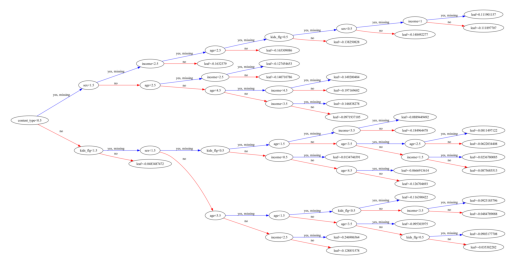

In [80]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plot_tree(xgb_model, num_trees=3, rankdir='LR')
plt.savefig("plot_tree.pdf")

In [63]:
predicted_y = xgb_model.predict(dmatris_test)
print(f"ROC AUC score = {roc_auc_score(y_test, predicted_y):.2f}")

ROC AUC score = 0.74


In [64]:
expected_y = y_test

In [73]:
predicted_y

array([0.04954508, 0.22284561, 0.12966387, ..., 0.12389306, 0.22761962,
       0.22932015], dtype=float32)

In [75]:
from sklearn import metrics
print(metrics.classification_report(expected_y, predicted_y.round(0)))
print(metrics.confusion_matrix(expected_y, predicted_y.round(0)))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92    169082
           1       0.37      0.30      0.33     23162

    accuracy                           0.85    192244
   macro avg       0.64      0.62      0.63    192244
weighted avg       0.84      0.85      0.85    192244

[[157174  11908]
 [ 16106   7056]]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

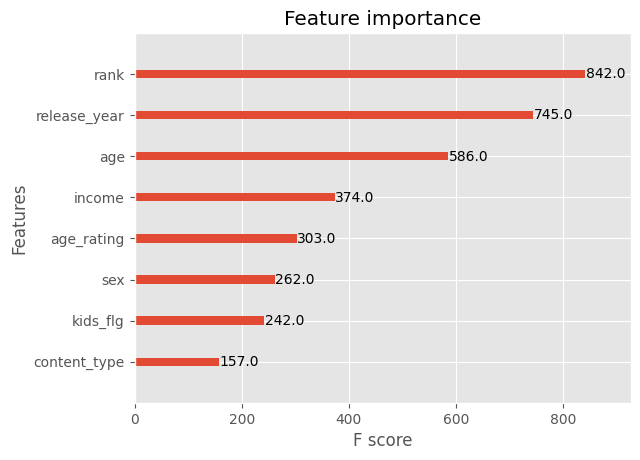

In [83]:
xgb.plot_importance(xgb_model)